In [1]:
import glob
glob.glob("../data/toxic/*.csv")

['../data/toxic/sample_submission.csv',
 '../data/toxic/test_labels.csv',
 '../data/toxic/test.csv',
 '../data/toxic/train.csv']

# Import libraries

In [187]:
import os
import pandas as pd
import re
import random
import numpy as np

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [150]:
file = "../data/toxic/train.csv"
data = pd.read_csv(file)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Exploration

In [4]:
rowsums=data.iloc[:,2:].sum(axis=1)
all_zero =(rowsums==0)

print("Total number of non toxic comments: ", all_zero.sum())
print("Total number of toxic comments: ", rowsums.sum())

Total number of non toxic comments:  143346
Total number of toxic comments:  35098


In [6]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
print("Number of rows with multiple labling: ", (rowsums > 1).sum())

Number of rows with multiple labling:  9865


We can see that multiple tweets have more than one classification and we can see many classfications in the toxic comments, however we only need to classify between toxic and non-toxic comments.

# Preprocessing

We are going to devide the dataset to just one class, instead of 6.   
The class Toxic has two posible values:   
0: Non-toxic comment   
1: Toxic comment   
   
The other 6 columns are droped out (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate)   
If the tweet has at least one non-zero value in any of the 6 last classes, it is set as 1 in the new class, otherwise as 0.

In [151]:
def typeComment(df):
    # If the comment has value more than 0, then it is  toxic. Otherwise non-toxic
    score=list(df.sum(axis = 1, skipna = True))
    new_score = [1 if (x>0) else 0 for x in score]
    return(new_score)
data['Toxic'] = typeComment(data)
toxic_columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
data = data.drop(columns=toxic_columns)
data.head()

,id,comment_text,Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [8]:
data.dtypes

id              object
comment_text    object
Toxic            int64
dtype: object

All the special chars will be deleted.   
The regular expressions (RE_PATTERNS) are for the more common words which can be written in multiple ways for the toxic comments.

In [152]:
special_chars = r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]"
RE_PATTERNS = {
    ' fuck':['(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)','(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            'feck ', ' fux ', 'f\*\*', 'f\-ing', 'f u u c', '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',' fu ',
            'f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f\.u\.', 'f###', 'f@ck', 'f u c k', 'f uck', 'f ck' ],
    ' ass ':['[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$', '[^a-z]anus', ' a\*s\*s', 
        '[^a-z]ass[^a-z ]', 'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'],
    ' ass hole ':[' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'],
    ' bitch ':['(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)', 'b!tch','bi\+ch', 'b!\+ch',
               'b[w]*i[t]*ch','biatch', 'bi\*\*h', 'bytch', 'b i t c h'],
    ' bastard ':['ba[s|z]+t[e|a]+rd'],
    ' dick ':[' dick[^aeiou]', 'deek', 'd i c k'],
    ' suck ':[ 'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'],
    ' cunt ':['c u n t'],
    ' bull shit ':[ 'bullsh\*t', 'bull\$hit'],
    ' idiot ':['i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)','idiots','i d i o t'],
    ' cock ':['[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'],
    ' dumb ':['(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'],
    ' shit ':['shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'],
    ' shit hole ':['shythole'],
    ' retard ':['returd', 'retad', 'retard', 'wiktard', 'wikitud'],
    ' rape ':['raped'],
    ' dumb ass':['dumbass', 'dubass'],
    ' ass head':['butthead'],
    ' nigger ':['nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'],
    ' shut the fuck up': ['stfu'],
    ' pussy ': ['pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'],
    ' faggot ':['faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',],
    ' mother fucker':[' motha ', ' motha f', ' mother f', 'motherucker'],
    ' whore ':['wh\*\*\*', 'w h o r e'],
    ' ':['h[\S]+//[\S]+']
}

In [153]:
class preprocessing(object):
    def __init__(self,special_chars, pattern):
        self.pattern = pattern
        self.special_chars = special_chars
    def cleanString(self,s):
        # remove special chars
        if self.special_chars is not None:
            s = re.sub(self.special_chars, ' ', s)
        s = s.replace("\\n", " ").replace("\n", " ")
        # Regular expressions
        pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
        s = pattern.sub(r"\1", s)
        tokenizer = TweetTokenizer()
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
        return " ".join(cleaned_words)

    def stemWords(self,sentence):
        stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
        stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
        return " ".join(stemmed_words)

    def cleanFrame(selfdev,frame):
        frame['clean_comment'] = frame.comment_text.apply(selfdev.cleanString)

    def stemFrame(selfdev,frame):
        frame['stem_comment'] = frame.clean_comment.apply(selfdev.stemWords)



Preprocessing=preprocessing(special_chars, RE_PATTERNS)
Preprocessing.cleanFrame(data)
Preprocessing.stemFrame(data)

The function cleanString hands with the special characters, regular expressions, stop words (for English).
The function stemWords stems the words already cleaned.
cleanFrame adds a new column "clean_comment", with the tweets already cleaned by applying the function cleanString
stemFrame got the new clean "clean_comment" from cleanFrame and apply in it stemWords, this is saved in a new column "stem_comment", this is the one which is going to be used for the classification.

In [16]:
data.head()

,id,comment_text,Toxic,clean_comment,stem_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,xplanation hy edits made username ardcore etal...,xplanat hy edit made usernam ardcor etallica r...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,' aww ! e matches background colour ' seemingl...,' aww ! e match background colour ' seemingli ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,"ey man , ' really trying edit war . t's guy co...","ey man , ' realli tri edit war . t' guy consta..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,ore can't make real suggestions improvement - ...,ore can't make real suggest improv - wonder se...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"ou , sir , hero . ny chance remember page that's","ou , sir , hero . ny chanc rememb page that'"


# Save data in a pickle

In [154]:
import pickle
path = "../data/toxic/"
toxic_comments_file = open(path + 'toxic_comments.pickle','wb') 
toxic_comments = data
pickle.dump(toxic_comments, toxic_comments_file)

# Load data

In [155]:
import pickle

path = "../data/toxic/"
toxic_comments_fread = open(path + 'toxic_comments.pickle','rb') 
data = pickle.load(toxic_comments_fread)
data.head()

,id,comment_text,Toxic,clean_comment,stem_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,xplanation hy edits made username ardcore etal...,xplanat hy edit made usernam ardcor etallica r...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,' aww ! e matches background colour ' seemingl...,' aww ! e match background colour ' seemingli ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,"ey man , ' really trying edit war . t's guy co...","ey man , ' realli tri edit war . t' guy consta..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,ore can't make real suggestions improvement - ...,ore can't make real suggest improv - wonder se...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,"ou , sir , hero . ny chance remember page that's","ou , sir , hero . ny chanc rememb page that'"


# Vectorize

The data is split for training and test with a rate 80-20.

In [174]:

X_train, X_test, y_train, y_test = train_test_split(data.stem_comment, data.Toxic, test_size=0.2,
                                                    random_state=np.random)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(127656,) (31915,) 127656 31915


First we tokenize X_train and X_test

In [175]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [176]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
max(totalNumWords)

1333

The max number of words in a comment is 1333, however this is too long to be worked with all the tweets with that extension, and this means several 0 values in almost all the tweets, so we decided to explore the distribution in all the tweets so cut the vectors to a defined lenght.   
This lenght (maxlen) must represent almot all the information but with a significative reduction. of space.

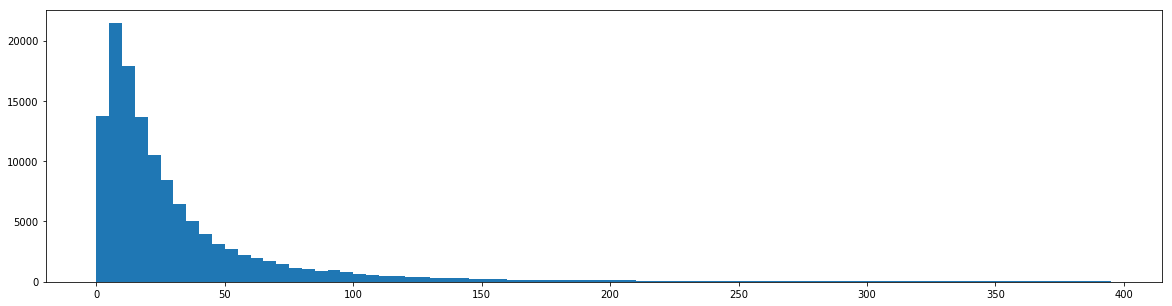

In [177]:
fig= plt.figure(figsize=(20,5))
plt.hist(totalNumWords,bins = np.arange(0,400,5))#(0,1300,5)
plt.show()

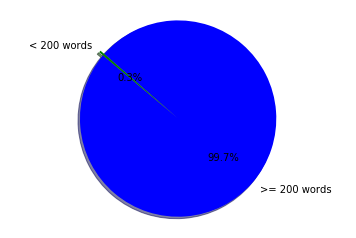

In [178]:
maxlen=400
counter=0
for i in totalNumWords:
    if i>=maxlen:
        counter+=1
        
labels = ['>= 200 words','< 200 words']
sizes = [len(totalNumWords),counter]
colors = ['blue', 'green']
# Data to plot
explode = (0, 0.05)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

After Analyze the distribution, we decided to set the maxlen in 400, this means a reduction of 70% in the lenght for the vectors, and this cut off only affects to the 0.3% of the data, afther this maxlens this percentage decrease too slowly.

In [161]:
class ModelROC:
    def __init__(self, model, X_test, y_test, legend):
        self.model = model
        y_pred = self.getPredictions(X_test)
        fpr, tpr, treshold = roc_curve(y_test, y_pred)
        self.fpr = fpr
        self.tpr = tpr
        self.treshold = treshold
        self.auc = auc(fpr, tpr)
        self.legend = legend
        print("Area under the curve " + self.legend + " " + str(self.auc))
    
    def getPredictions(self, X_test):
        return self.model.predict(X_test)
    
    def plotData(self):
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr, self.tpr, label= self.legend + ' (area = {:.3f})'.format(self.auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        
    def plot(self):
        plt.figure(1)
        self.plotData()
        plt.show()

In [179]:
V_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
V_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(V_train.shape,V_test.shape)

(127656, 400) (31915, 400)


In [193]:
def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(40, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [192]:
model = getModel()
batch_size = 32
epochs = 15

file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, 
          validation_split=0.1, callbacks=callbacks_list)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print (model.predict(training_data).round())

model.load_weights(file_path)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 114890 samples, validate on 12766 samples
Epoch 1/15
 85696/114890 [=====================>........] - ETA: 2:43 - loss: 0.1703 - accuracy: 0.9405

KeyboardInterrupt: 

# Load the model

In [196]:
from keras.models import load_model
saved_model = load_model(file_path)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [198]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 400)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 400, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           45360     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 60)                0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 40)                2440      
_________________________________________________________________
dropout_28 (Dropout)         (None, 40)                0  

In [205]:
model.evaluate(V_test, y_test, verbose=1, use_multiprocessing=False)

31915/31915 [==============================] - 41s 1ms/step


[0.12353804550228047, 0.9552561640739441]

Area under the curve Keras 0.9619546827081978


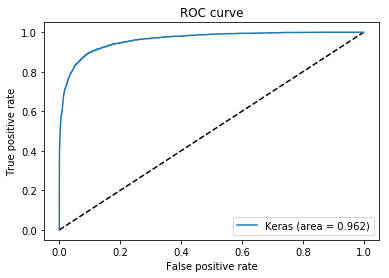

In [220]:
km = ModelROC(model, V_test, y_test, "Keras")
km.plot()

# Classification Report

In [219]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

y_pred = model.predict(V_test)
print(classification_report(y_test,y_pred.round(),digits=2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     28757
           1       0.82      0.71      0.76      3158

    accuracy                           0.96     31915
   macro avg       0.89      0.84      0.87     31915
weighted avg       0.95      0.96      0.95     31915



View of the predicted toxic comments

In [290]:
for i,id in enumerate(X_test.index):
    if y_pred[i].round()==1:
        print("\tToxic" if (y_test[id]==1) else "\tNon-toxic")
        print(data["comment_text"][id])

	Toxic
Dickhead
You know it was stupid, you know it wasn't clever. So why do it? 94.195.251.61
	Toxic
Member of the gaming community are you? Stupid wikipedia loser
	Toxic
fuck-sucking 

Kindly find the nearest fuck and suck it.
	Non-toxic
"
""a day or so to mull it over"" is exactly where I'm at too; so much has been thrown up on talk, that time out is needed to digest and look into before we can pretend to make sence of it. As for the talk page stuff; its not like it matters, just the usual 5% idiot fringe that make life typically difficult for the other 95% of us.   "
	Non-toxic
I KNOW YOU FROM SOULSEEK!!

lololol
	Toxic
OK YOU. LIKE I SAID THIS IS MY WORLD, I DECIDE WHAT HAPPENS. IF I SAY LIL CHRIS DIED OF MALARIA, THEN IT HAPPENED. END OF. JUST ME SAYING IT AUTOMATICALLY MAKES IT TRUE, THEREFORE IT IS AN ACCURATE EDIT. GET IT?
	Toxic
, you stupid ass fucker, retarded whore, incompetent loser! I'm unblocked! Miss Ciara 15:52, 8 June 2006
	Non-toxic
nikko smells  nikko smells  nikko

	Toxic
"

haha you are a dumb shit. what's so wrong about ""nazi"" or ""hitler"". some dumb american shit that makes nazi or hitler some how incomparable to any other shit? you know what, many people in the world think your dumb american imperialism, assault on iraq, are comparable to the atrocities performed by the nazis. yet ""american"" or ""republican"" is not a diss.

let me say it right here out loud: TAS is almost as bad as Nazis!
 17:32, 20 Apr 2005 (UTC)"
	Non-toxic
WHY AM I BEING BLOCKED AND CENOSRED? WHY AM I NOT ALLOWED TO DISPUTE DEFAMATION POSTED AGAINST JEWS? WHERE ARE THE PERSONAL ATTACK?
	Non-toxic
"

""if a regime is hated and fear by it's Baixing, and only use para-military to squash any kind of protest, what will happen if Baixing begin to act like 陳胜吳廣? ""

I can assure CPC is not nearly as hated as you think. Minyuen is hated much more, for selling out China.  "
	Toxic
FUCK YOU I WON'T DO WHAT YOU TELL ME!-ANON
	Toxic
dude its not vandalism its the name of the son

	Toxic
"

 I still hate you 

because you destroyed the TOTSE ""Holden DaPenor"" project.  75.57.162.172  "
	Toxic
look here you small penis faggot, you better watch your mouth or you going to get knocked the fuck out over wiki fuking pedia! you watch but who watches you!!!
your life is overrrrrrrrrrrrrrrrrrr
	Toxic
my name is reaper eternal and i am a stupid dumasss small dik retard
	Toxic
go kill yourself, nobody cares about standardization
	Toxic
I really hate you tommy i dont understand why you cant be actually nice for a sec and listen to my input. now you are being a pussy bitch by deleting everything i post. I hope bad things happen to you tommy. Bad things. Fuck you
	Toxic
FUCK YOU ! 

FUCK YOU ! BITCH, ILL SHOW UR GAME GUIDE.
	Toxic
I wrote that shit ages ago, what are you a slaking faggot
	Non-toxic
"
   

   Aah, the WikiCop once again...nothing better to do with your life than to talk to people like they're idiots.  I deleted a talk section that contained no actual sections